In [3]:
from datascience import *
import numpy as np
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
%matplotlib inline

### Load compensation data for 2019 San Francisco.

In [4]:
sf2019 = Table().read_table("san_francisco_2019.csv")

In [5]:
sf2019.show(3)

Organization Group,Department,Job Family,Job,Salary,Overtime,Benefits,Total Compensation
Public Protection,Adult Probation,Information Systems,IS Trainer-Journey,91332,0,40059,131391
Public Protection,Adult Probation,Information Systems,IS Engineer-Assistant,123241,0,49279,172520
Public Protection,Adult Probation,Information Systems,IS Business Analyst-Senior,115715,0,46752,162468


In [6]:
# what does the mayor make?
sf2019.where('Job', 'Mayor')

Organization Group,Department,Job Family,Job,Salary,Overtime,Benefits,Total Compensation
General Administration & Finance,Mayor,Administrative & Mgmt (Unrep),Mayor,342974,0,98012,440987


In [8]:
# let's focus on Total Compensation
sf2019.sort('Total Compensation').show(4)

Organization Group,Department,Job Family,Job,Salary,Overtime,Benefits,Total Compensation
Public Protection,Adult Probation,Probation & Parole,Deputy Probation Officer,0,0,0,0
Public Protection,Fire Department,"Clerical, Secretarial & Steno",Senior Clerk Typist,0,0,0,0
Public Protection,Juvenile Court,Correction & Detention,"Counselor, Juvenile Hall PERS",0,0,0,0
Public Protection,Police,"Clerical, Secretarial & Steno",Clerk Typist,0,0,0,0


In [10]:
# weird zeroes because some people start work late in the year, etc...
# let's filter out these and focus on people who made at least $15,000
sf2019 = sf2019.where("Salary", are.above(15000))

# how many is that?
sf2019.num_rows

37103

## Let's let these 37000 rows be our population.
### compute a histogram of compensation.

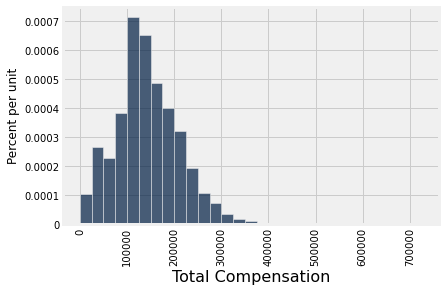

In [12]:
sf_bins = np.arange(0, 726000, 25000)
sf2019.select('Total Compensation').hist(bins=sf_bins)


In [13]:
# Most are <300K, but some are way above that
# Let's look at the top two:
sf2019.sort('Total Compensation', descending=True).show(2)


Organization Group,Department,Job Family,Job,Salary,Overtime,Benefits,Total Compensation
General Administration & Finance,Retirement Services,Administrative & Mgmt (Unrep),Chief Investment Officer,577633,0,146398,724031
General Administration & Finance,Retirement Services,Unassigned,Managing Director,483072,0,134879,617951


In [14]:
# Let's calculate the median of Total Compensations:
# remember that is the value at the 50th percentile:
pop_median = percentile(50, sf2019.column('Total Compensation'))
pop_median


135747.0

## but what if we couldn't estimate this parameter?
### we will estimate based on a random sample.

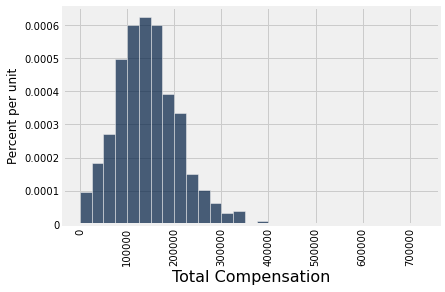

In [21]:
# Let's draw 500 employees at random:
our_sample = sf2019.sample(500, with_replacement=False)
our_sample.select('Total Compensation').hist(bins=sf_bins)


In [22]:
# Then pretend that the median from the random sample is our estimate
# of the parameter
est_median = percentile(50, our_sample.column('Total Compensation'))
est_median


136781.0

### We have a large random sample.
### It is likely to resemble the population from which it was drawn.
### Let's resample from it, with replacement (bootstrap).
#### 1) Treat the original sample as if it were from the population.
#### 2) Draw from that sample at random w replacement the same number of times.

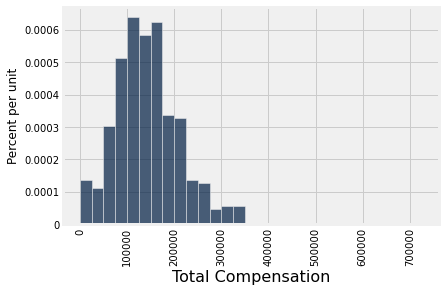

In [32]:
resample_1 = our_sample.sample()
resample_1.select('Total Compensation').hist(bins=sf_bins)


In [33]:
# Estimate the median from the resample.
resampled_median_1 = percentile(50, resample_1.column('Total Compensation'))
resampled_median_1


136209.0

In [34]:
# DO it again:
resample_2 = our_sample.sample()
resampled_median_2 = percentile(50, resample_2.column('Total Compensation'))
resampled_median_2


136781.0

In [35]:
# we will collect this code a define a function
# the function will return one bootstrap median of TC,
# based on bootstratpping the original random sample our_sample.

def one_bootstrap_median():
    resampled_table = our_sample.sample()
    bootstrapped_median = percentile(50, resampled_table.column('Total Compensation'))
    return bootstrapped_median

In [48]:
# now run it a few times to see how they vary.
one_bootstrap_median()


138477.0

In [49]:
# Let's repeat it a large number of times 
# 1 - use the function to generate one value of bootstrapped median
# 2 - append the bootstrapped median to the array bstrap_medians
num_repetitions = 5000
bstrap_medians = make_array()
for i in np.arange(num_repetitions):
    bstrap_medians = np.append (bstrap_medians, one_bootstrap_median())


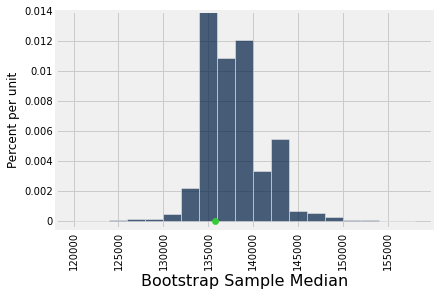

In [51]:
# Empirical histogram of 5000 bootstrapped medians
# and add the median from the original population (~37,000)
resampled_medians = Table().with_column('Bootstrap Sample Median', bstrap_medians)
median_bins=np.arange(120000, 160000, 2000)
resampled_medians.hist(bins = median_bins)

# Plotting parameters; you can ignore this code
parameter_green = '#32CD32'
plots.ylim(-0.000005, 0.00014)
plots.scatter(pop_median, 0, color=parameter_green, s=40, zorder=2);


In [ ]:
# You can see how the population mean falls within the 
# randomly generated sampled medians.
# If it doesn't then our esimates are off.

In [54]:
# DO the middle 95% interval of resampled medians contain the green dot?
left = percentile(2.5, bstrap_medians)
left


133424.0

In [55]:
right = percentile(97.5, bstrap_medians)
right


144639.0

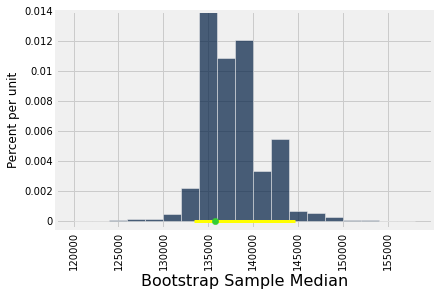

In [56]:
resampled_medians.hist(bins = median_bins)

# Plotting parameters; you can ignore this code
plots.ylim(-0.000005, 0.00014)
plots.plot([left, right], [0, 0], color='yellow', lw=3, zorder=1)
plots.scatter(pop_median, 0, color=parameter_green, s=40, zorder=2);


# Confidence Intervals
#### Above we produced an interval of estimates
#### This accounts for chance variability in the random sample.
#### It gives us wiggle room!
#### These intervals contain the parameter

In [59]:
# Let's use the bootstrap method to estimate an unknown population median.
births = Table.read_table('baby.csv')
births.show(3)


Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True


In [62]:
# Let's estimate birth weight before the baby is born.
# we'll use the ratio of birth weight and # of gestational days.
ratios = births.select('Birth Weight', 'Gestational Days').with_columns(
    'Ratio BW:GD', births.column('Birth Weight')/births.column('Gestational Days')
)


In [61]:
ratios

Birth Weight,Gestational Days,Ratio BW:GD
120,284,0.422535
113,282,0.400709
128,279,0.458781
108,282,0.382979
136,286,0.475524
138,244,0.565574
132,245,0.538776
120,289,0.415225
143,299,0.478261
140,351,0.39886


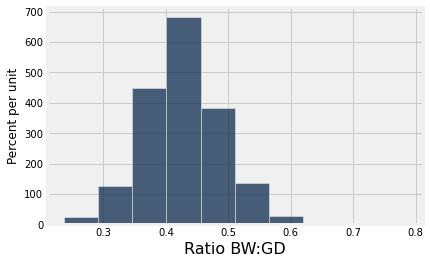

In [63]:
ratios.select('Ratio BW:GD').hist()


In [65]:
# The histogram looks symmetric, but let's see what
# the largest ratios are:
ratios.sort('Ratio BW:GD', descending=True).take(0)


Birth Weight,Gestational Days,Ratio BW:GD
116,148,0.783784


In [66]:
# Now let's calculate the median ratio in the sample
percentile(50, ratios.column(2))


0.42907801418439717

### But what is the median of the population? 
#### Here, we will create 5000 bootstraps of the median
#### The 95% confidence interval will be the middle 95% of all of our estimates.

In [72]:
# Let's write a function that bootstraps the sample
# and returns one median ratio from the bootstrapped sample.
def one_bootstrap_median():
    resample = ratios.sample()
    return percentile(50, resample.column('Ratio BW:GD'))


In [73]:
one_bootstrap_median()

0.427536231884058

In [74]:
# Generate medians from 5000 bootstrap samples
num_repetitions = 5000
bstrap_medians = make_array()
for i in np.arange(num_repetitions):
    bstrap_medians = np.append(bstrap_medians, one_bootstrap_median())


In [75]:

# Get the endpoints of the 95% confidence interval
left = percentile(2.5, bstrap_medians)
right = percentile(97.5, bstrap_medians)

make_array(left, right)


array([0.42545455, 0.43262411])

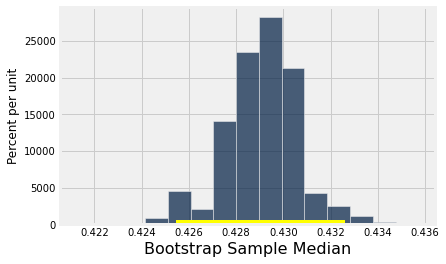

In [76]:
resampled_medians = Table().with_columns(
    'Bootstrap Sample Median', bstrap_medians
)
resampled_medians.hist(bins=15)
plots.plot([left, right], [0, 0], color='yellow', lw=8);


In [ ]:
# Here we've plotted the 95% confidence interval of estimates,
# but did not plot the green dot - we don't know where it is (wink wink)
# 95% of the time, the population median should be between this interval.


### Using a Confidence Interval to Test Hypotheses
We will study this in the context of data that are a subset of the information gathered in a randomized controlled trial about treatments for Hodgkin’s disease. Hodgkin’s disease is a cancer that typically affects young people. The disease is curable but the treatment can be very harsh. The purpose of the trial was to come up with dosage that would cure the cancer but minimize the adverse effects on the patients.

In [79]:
hodgkins = Table.read_table('hodgkins.csv')
hodgkins.show(3)


height,rad,chemo,base,month15
164,679,180,160.57,87.77
168,311,180,98.24,67.62
173,388,239,129.04,133.33


A measure of radiation to the mantle (neck, chest, under arms)

A measure of chemotherapy

A score of the health of the lungs at baseline, that is, at the start of the treatment; higher scores correspond to more healthy lungs

The same score of the health of the lungs, 15 months after treatment

In [81]:
# We will compare the baseline and 15-month scores. 
# At a glance, you can see that the 15-month scores 
# tend to be lower than the baseline scores – the sampled patients’ 
# lungs seem to be doing worse 15 months after the treatment. 

# look at the column 'drop', which is mostly positive:
hodgkins = hodgkins.with_columns(
    'drop', hodgkins.column('base') - hodgkins.column('month15')
)
hodgkins

height,rad,chemo,base,month15,drop
164,679,180,160.57,87.77,72.8
168,311,180,98.24,67.62,30.62
173,388,239,129.04,133.33,-4.29
157,370,168,85.41,81.28,4.13
160,468,151,67.94,79.26,-11.32
170,341,96,150.51,80.97,69.54
163,453,134,129.88,69.24,60.64
175,529,264,87.45,56.48,30.97
185,392,240,149.84,106.99,42.85
178,479,216,92.24,73.43,18.81


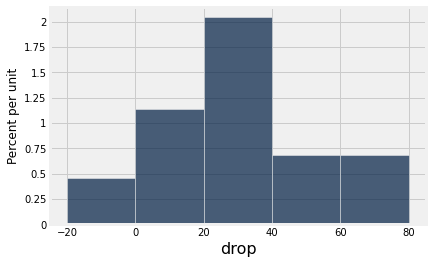

In [84]:
hodgkins.select('drop').hist(bins=np.arange(-20, 81, 20))


In [85]:
np.average(hodgkins.column('drop'))


28.615909090909096

In the sample, the average drop is about 28.6.

Is this due to chance variation?

The data are from a random sample.

What if the average drop is zero in the population, and the sample is not representative?

### We will set up two hypotheses:
#### 1. Null hypothesis - in the population the average drop is zero.
#### 2. Alternate hypothesis - in the population, the average drop is not zero.

To test these hypotheses, we'll use a 1% cut off for the p-value.

That means we need to construct a 99% confidence interval for the average drop in the popualtion.

In [86]:

def one_bootstrap_mean():
    resample = hodgkins.sample()
    return np.average(resample.column('drop'))


In [87]:
# Generate 10,000 bootstrap means
num_repetitions = 10000
bstrap_means = make_array()
for i in np.arange(num_repetitions):
    bstrap_means = np.append(bstrap_means, one_bootstrap_mean())


In [88]:
# Get the endpoints of the 99% confidence interval
left = percentile(0.5, bstrap_means)
right = percentile(99.5, bstrap_means)

make_array(left, right)


array([17.13863636, 40.53409091])

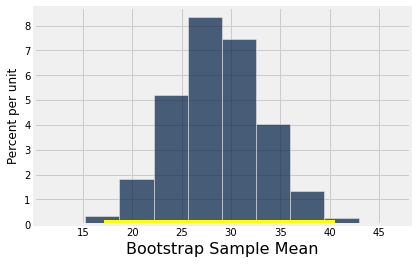

In [89]:
resampled_means = Table().with_columns(
    'Bootstrap Sample Mean', bstrap_means
)
resampled_means.hist()
plots.plot([left, right], [0, 0], color='yellow', lw=8);


In [90]:
# The 99% confidence interval for the average drop in the population goes from about 17 to about 40. 
# The interval doesn’t contain 0. So we reject the null hypothesis!!!